# Pre-visualizing

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import xarray as xr
print('All packages imported.')

All packages imported.


## Site Selection

In [16]:
site = widgets.Select(
    options=['hfe-M1', 'nsa-C1', 'sgp-C1', 'twp-C1', 'twp-C2', 'twp-C3'],
    value='twp-C1',
    rows=6,
    description='ARM Site:',
    disabled=False
)


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print(f"Switch site to {change['new']}")


site.layout.width = '175px'
site.observe(on_change)
display(site)

Select(description='ARM Site:', index=3, layout=Layout(width='175px'), options=('hfe-M1', 'nsa-C1', 'sgp-C1', …

Switch site to hfe-M1
Switch site to sgp-C1
Switch site to twp-C1
Switch site to twp-C2
Switch site to twp-C3


In [32]:
product = widgets.Select(
    options=['armbeatm'],
    value='armbeatm',
    rows=1,
    description='Product:',
    disabled=False
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print(f"Switch site to {change['new']}")
              
product.layout.width = '175px'
product.observe(on_change)
display(product)

Select(description='Product:', layout=Layout(width='175px'), options=('armbeatm',), rows=1, value='armbeatm')

## Data Import

In [33]:
def site2stream(site, product):
    region, index = site.split('-')
    stream = region+product+index
    print(f'Ready for data stream: {stream}')
    return stream

def get_ARM_files_path(site, stream, ext='nc'):
    CURRENT_DIR = os.getcwd()
    DATA_DIR = f'{CURRENT_DIR}/../../data/ARM/{site}/{stream}'
    FILE_PATH = f'{DATA_DIR}/{stream}.*.{ext}'
    return FILE_PATH

def get_DS(mf):
    return xr.open_mfdataset(mf)

In [52]:
stream = site2stream(site.value, product.value)
FILE_PATH = get_ARM_files_path(site=site.value, stream=stream, ext='cdf')
DS = get_DS(FILE_PATH)
DS

Ready for data stream: twparmbeatmC3


<xarray.Dataset>
Dimensions:        (p: 37, range: 2, time: 78888, z: 512)
Coordinates:
  * time           (time) datetime64[ns] 2002-01-01T00:30:00 ... 2010-12-31T23:30:00
  * p              (p) float32 1000.0 975.0 950.0 925.0 ... 150.0 125.0 100.0
  * z              (z) float32 15.0 60.0 105.0 150.0 ... 22920.0 22965.0 23010.0
    z10            float32 10.0
    z2             float32 2.0
Dimensions without coordinates: range
Data variables:
    base_time      (time) datetime64[ns] 2002-01-01 2002-01-01 ... 2010-01-01
    time_offset    (time) datetime64[ns] dask.array<shape=(78888,), chunksize=(8760,)>
    time_bounds    (time, range) datetime64[ns] dask.array<shape=(78888, 2), chunksize=(8760, 2)>
    time_frac      (time) datetime64[ns] dask.array<shape=(78888,), chunksize=(8760,)>
    p_bounds       (time, p, range) float64 dask.array<shape=(78888, 37, 2), chunksize=(8760, 37, 2)>
    z_bounds       (time, z, range) float64 dask.array<shape=(78888, 512, 2), chunksize=(8760, 512,

## Variable Validity 

In [35]:
from utils importport DS_count_valid

In [53]:
cnt_valid = DS_count_valid(DS)
cnt_valid

,#valid
var,
base_time,78888
time_offset,78888
time_bounds,78888
time_frac,78888
p_bounds,78888
z_bounds,78888
u_sfc,73530
v_sfc,73529
T_sfc,73498


In [37]:
min_cnt_valid = widgets.FloatText(
    value=0,
    description='Min valid count:',
    disabled=False
)
min_cnt_valid.layout.width = '175px'
display(min_cnt_valid)

FloatText(value=0.0, description='Min valid count:', layout=Layout(width='175px'))

In [54]:
var_interest = list(cnt_valid.index[(cnt_valid['#valid'] != cnt_valid['#valid'].max()) & (cnt_valid['#valid'] >= min_cnt_valid.value)])
var_interest

['u_sfc',
 'v_sfc',
 'T_sfc',
 'rh_sfc',
 'p_sfc',
 'prec_sfc',
 'T_p',
 'T_z',
 'Td_p',
 'Td_z',
 'rh_p',
 'rh_z',
 'u_p',
 'u_z',
 'v_p',
 'v_z']

# Visualization

Extract variables of interest

In [55]:
var_1d = [var for var in var_interest if (not '_p' in var) & (not '_z' in var)]
var_2d = [var for var in var_interest if ('_p' in var)]
print(f'1-dim variables: {var_1d}')
print(f'2-dim variables: {var_2d}')

plev = DS['p'].values.astype(np.int32)  # array of pressure level

1-dim variables: ['u_sfc', 'v_sfc', 'T_sfc', 'rh_sfc', 'p_sfc', 'prec_sfc']
2-dim variables: ['T_p', 'Td_p', 'rh_p', 'u_p', 'v_p']


## Basics

In [41]:
def plot_1d(DS, var_1d=var_1d):
    time_value = DS.time.values
    for var_str in var_1d:
        x_value = DS[var_str].values
        fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
        
        sns.scatterplot(x_value, time_value, s=3, ax=ax[0])
        ax[0].set(xlabel=var_str, ylabel='Year')
        
        sns.distplot(x_value[~np.isnan(x_value)]) # distplot cannot handle NaN itself
        ax[1].set(xlabel=var_str, ylabel='Frequency')

        plt.show()
    return None


def plot_2d(DS, var_2d=var_2d):
    for var_str in var_2d:
        x_value = DS[var_str].values
        fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
        
        DS[var_str].plot(ax=ax[0])
        
        sns.distplot(x_value[~np.isnan(x_value)]) # distplot cannot handle NaN itself
        ax[1].set(xlabel=var_str, ylabel='Frequency')
        
        plt.show()
    return None


def binplot_prec(DS, bin_min):
    x_value = DS['prec_sfc'].values
    x_value = x_value[x_value>=bin_min]
    
    fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
        
    sns.distplot(x_value[~np.isnan(x_value)]) # distplot cannot handle NaN itself
    ax.set(xlabel='prec_sfc', ylabel='Frequency')

    plt.show()
    return None

/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


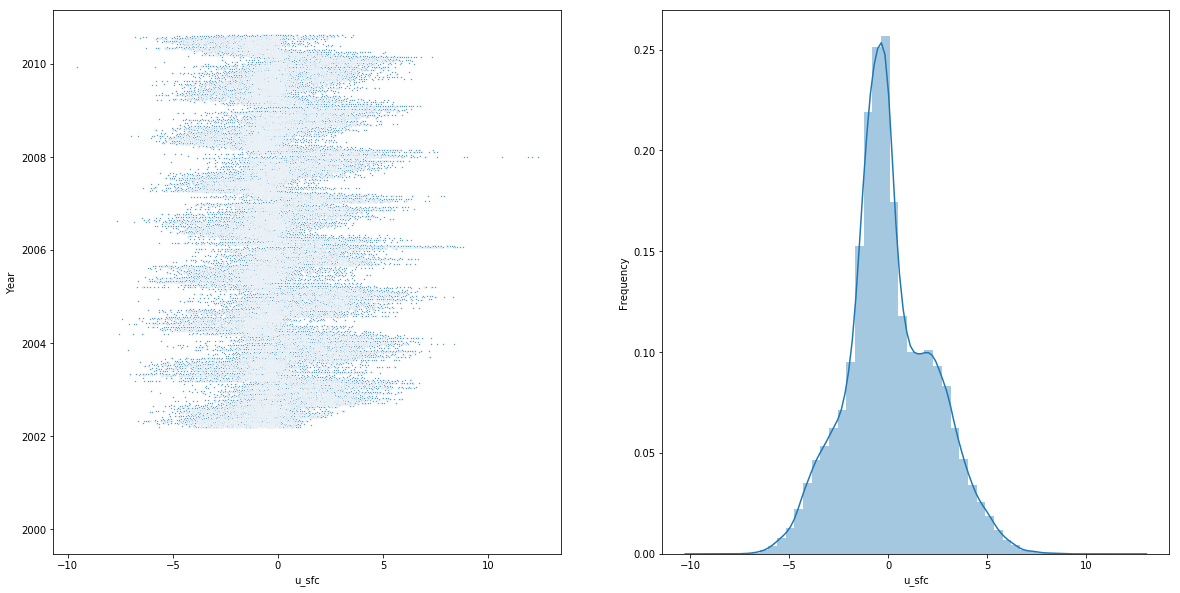

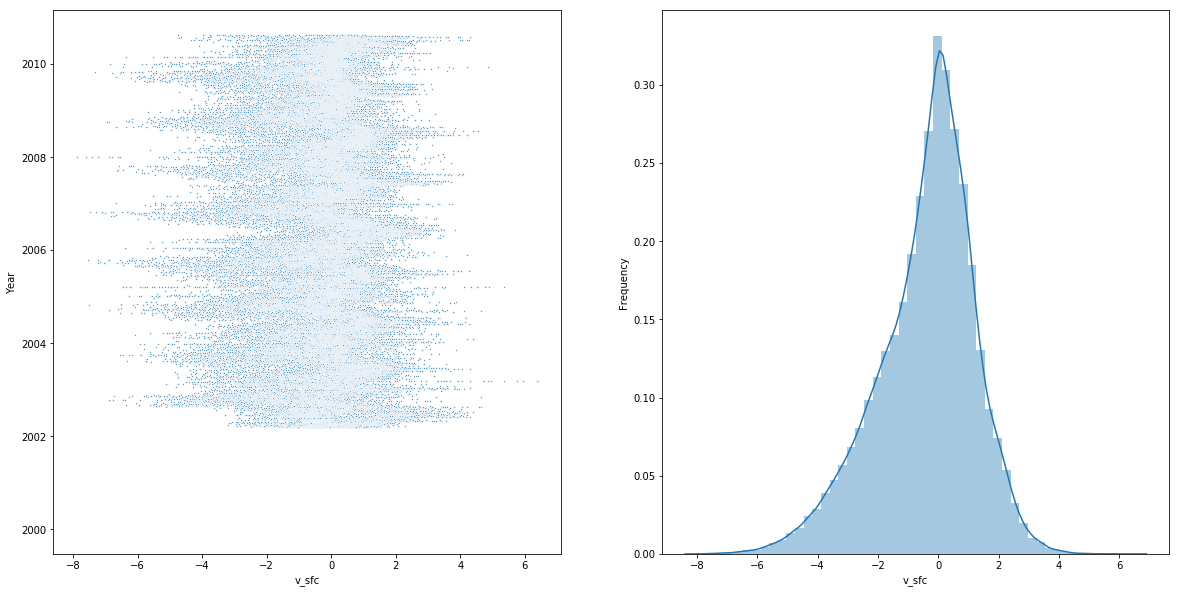

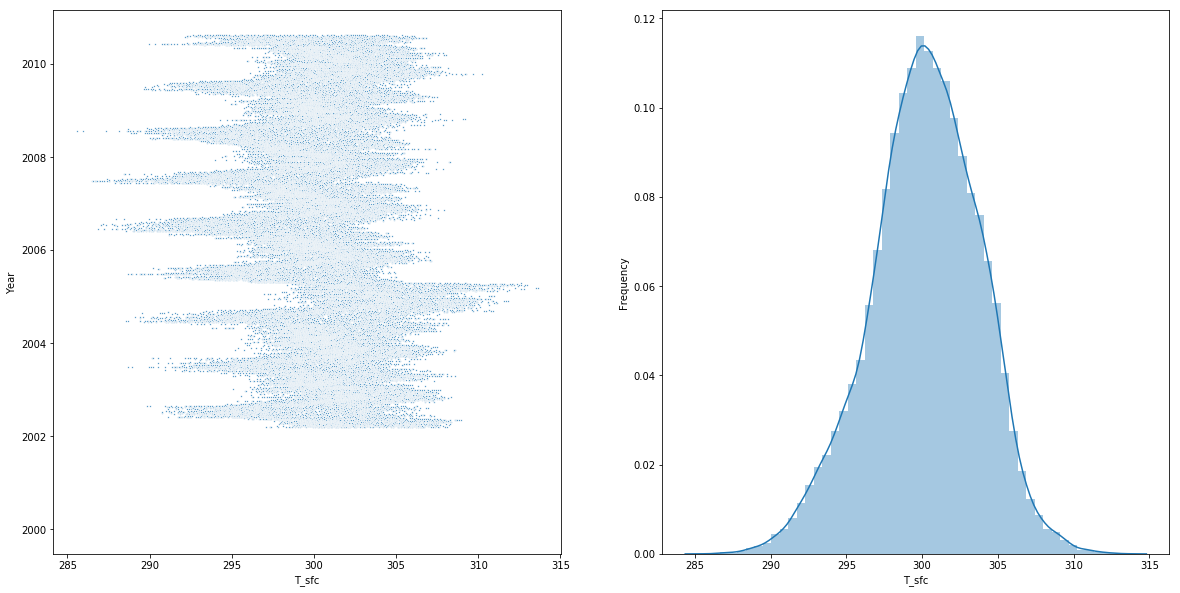

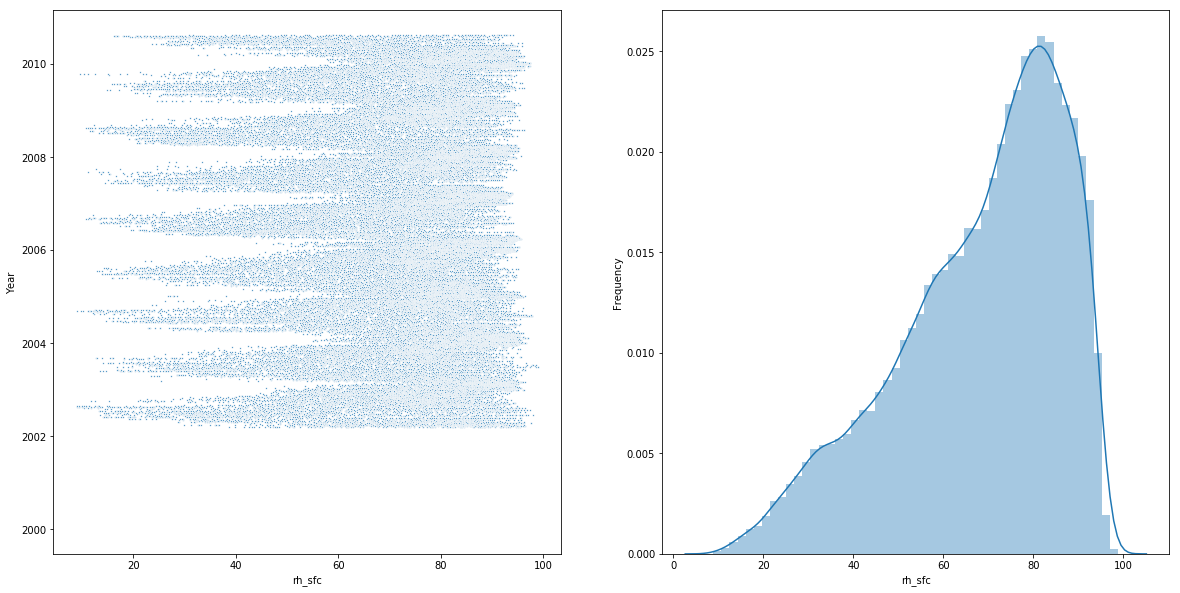

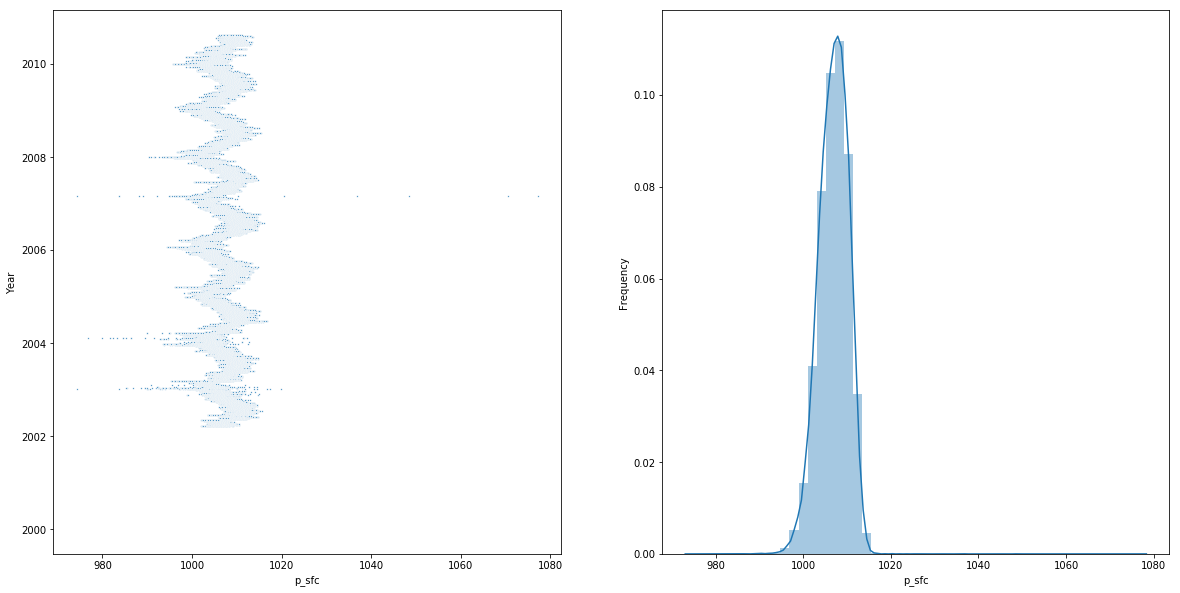

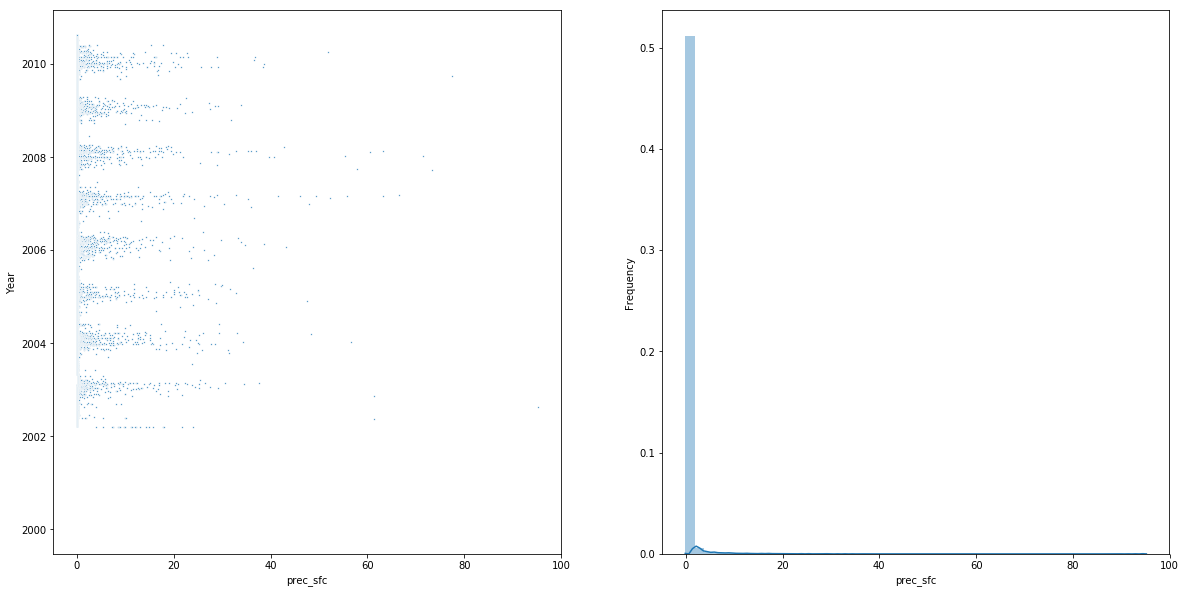

In [56]:
plot_1d(DS)

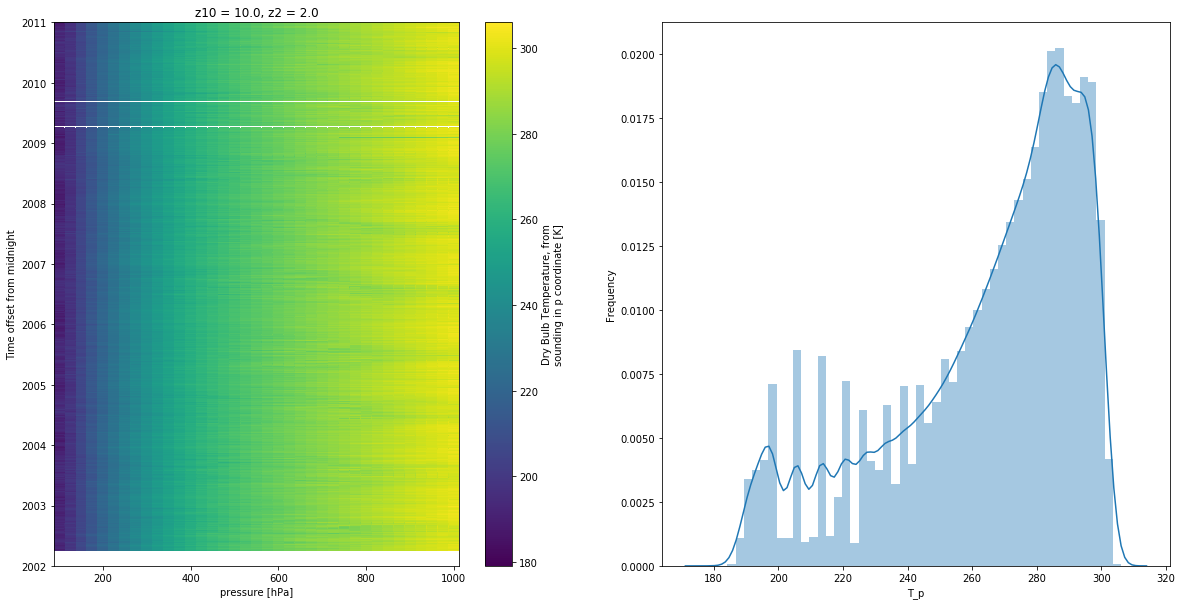

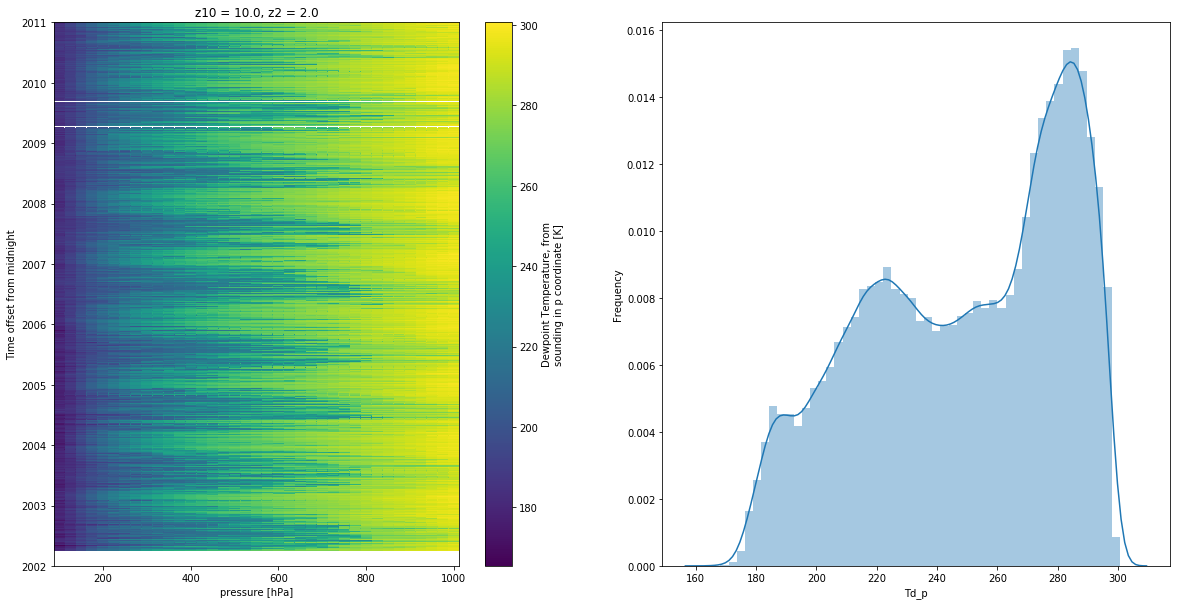

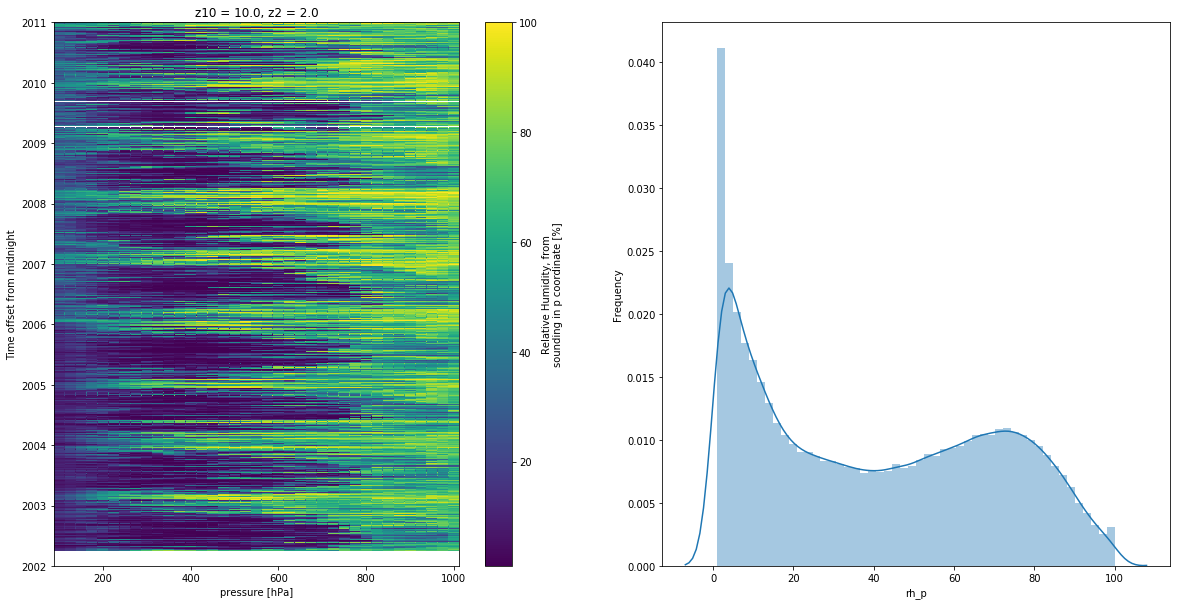

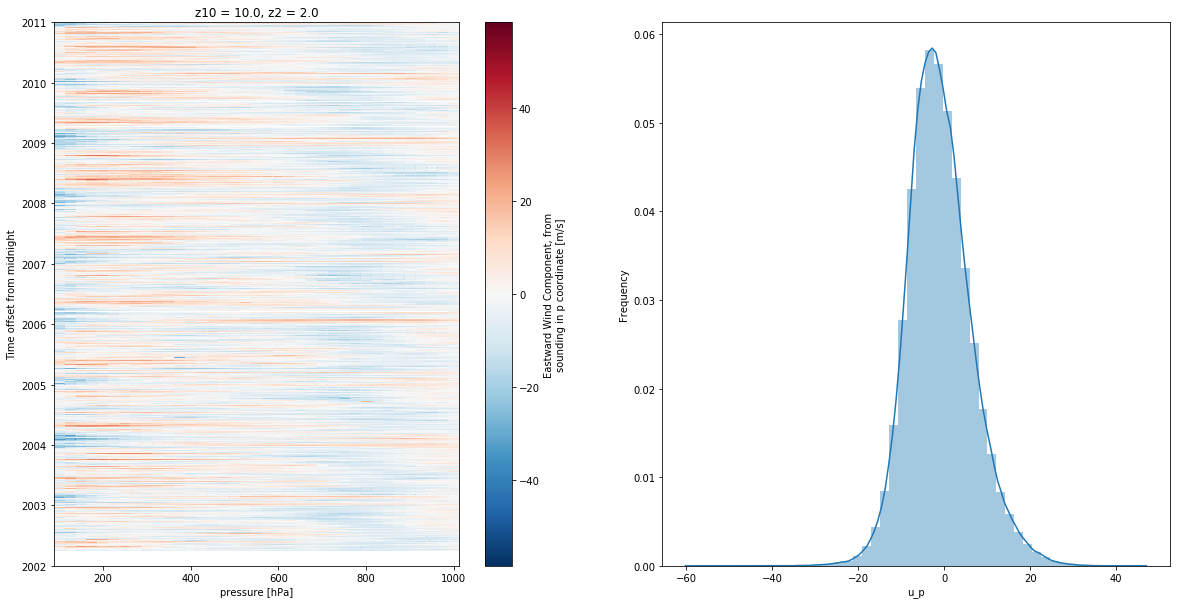

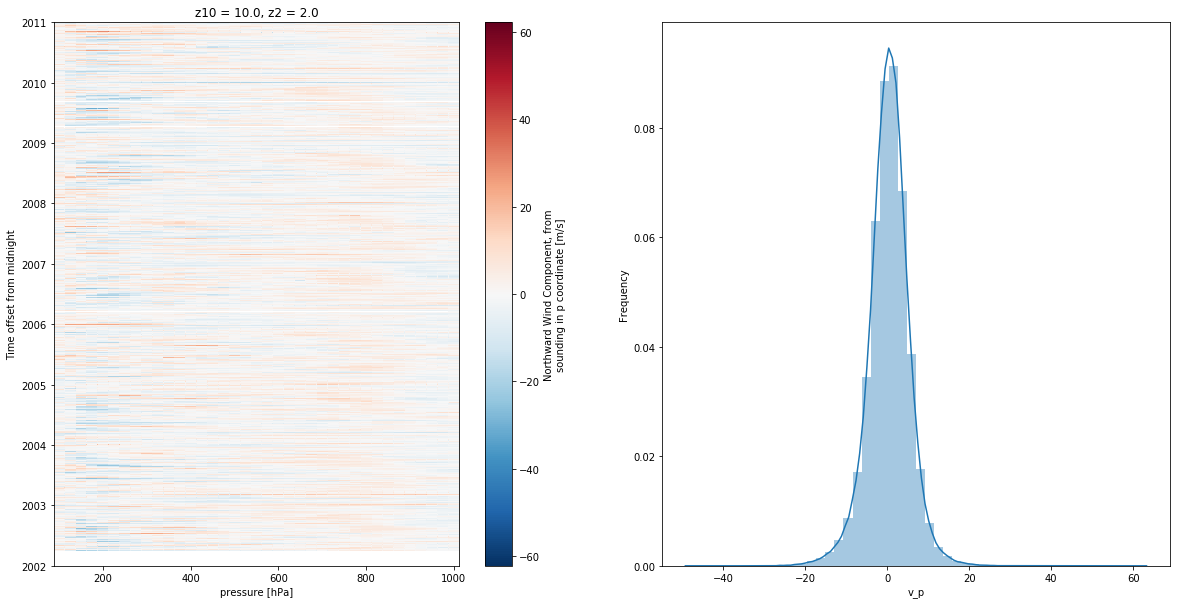

In [57]:
plot_2d(DS)

/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


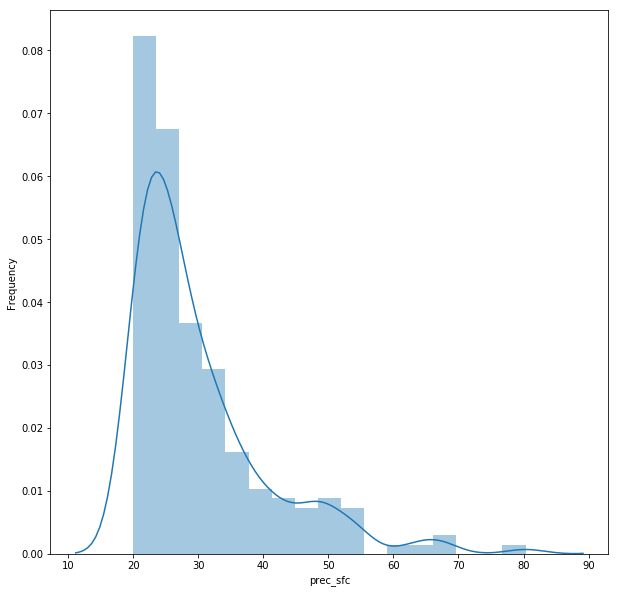

In [51]:
binplot_prec(DS, bin_min=20)

## DataFrame Conversion (under development)

In [40]:
trythis = DS['omega_nwp_p'].dropna(dim='time').values

In [76]:


def DS2df_1d(DS, cols, drop_cols=None):
    return DS[cols].to_dataframe().drop(columns=drop_cols)

'''
def DS2df_channels(DS, str_x_1d=str_x_1d):
    channels = [DS[str_x_1d[i]].to_dataframe().unstack(level=-1)
                for i in range(0, len(str_x_1d))]
    X_conv = np.expand_dims(channels[0].values, axis=2)

    for channel in channels[1:]:
        channel = np.expand_dims(channel.values, axis=2)
        X_conv = np.append(X_conv, channel, axis=2)

    return X_conv
    '''

'\ndef DS2df_channels(DS, str_x_1d=str_x_1d):\n    channels = [DS[str_x_1d[i]].to_dataframe().unstack(level=-1)\n                for i in range(0, len(str_x_1d))]\n    X_conv = np.expand_dims(channels[0].values, axis=2)\n\n    for channel in channels[1:]:\n        channel = np.expand_dims(channel.values, axis=2)\n        X_conv = np.append(X_conv, channel, axis=2)\n\n    return X_conv\n    '

In [77]:
df = DS2df_1d(DS, var_1d, ['z2', 'z10'])
df

,u_sfc,v_sfc,T_sfc,rh_sfc,p_sfc,prec_sfc
time,,,,,,
1996-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 04:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 05:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 06:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 07:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 08:30:00,NaN,NaN,NaN,NaN,NaN,NaN


## Advanced (under development)

In [ ]:
def pairplot(DS, cols_str, hue_str=None):
    sns_plot = sns.pairplot(df,
                            vars=cols_str,
                            hue=hue_str,
                            palette='bright',
                            diag_kind='kde',
                            plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
                            height=4)
    plt.show()


def corrplot(DS, annotate=False):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    sns_plot = sns.heatmap(corr,
                           mask=mask,
                           annot=annotate,
                           vmax=.5,
                           center=0,
                           square=True,
                           linewidths=.5,
                           cbar_kws={"shrink": .5})

    plt.title('Correlation matrix', fontsize=15)
    plt.show()